# Cryptocurrency Market Analysis

*Mohammed Jamil*

## Context

The first half of 2022 has been very bad for the crypto market. Crypto industry experts have mixed opinions about the future of cryptocurrencies. While some believe the market will continue to be volatile, others expect some stability in the second half of 2022.

In these uncertain times for the crypto market, is it still worth the risk investing in cryptocurrencies ? and what are the low-risk cryptocurrencies to consider ? These are some questions that we will try to answer in this exploratory analysis and the other notebooks included in this project.

## Table of Contents :

- Data collection.
- Market analysis.

---

### Data Collection :

First let's import the necessery libraries for this analysis and define some global variables and helper functions.

In [53]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import requests
import datetime
import time

In [36]:
#Let's define global variables.

current_date = datetime.date.today()

In [37]:
#Let's define some helper functions.

def date_to_posix_timestamp(date):
    """
    Converts datetime.date object or a date string into posix timestamp.
    NB: date string must be in iso format 'YYYY-MM-DD'.
    
    Params:
    -------
        date (datetime.date or string) - Date to convert.
    
    Returns:
    --------
        Posix timestamp (Integer).
    """
    
    if not isinstance(date, datetime.date):
        date = datetime.date.fromisoformat(date)
    
    timestamp = int(time.mktime(date.timetuple()))
    
    return timestamp

To collect cryptocurrency market data, we are going to use the **CoinGecko** API.

Before we start retreiving the historical data about cryptocurrency prices (USD), we need some general information about the currencies supported by the API. 

NB: We will limit this analysis only to the most popular cryptocurrencies.

In [43]:
def get_topN_currencies(n, vs_currency="usd"):
    """
    Retreives the top N cryptocurrencies with the highest market value (N_max = 250).
    
    Params:
    -------
        vs_currency (String) - The target currency of market data.
        n (Integer)          - Number of currencies.
    
    Returns:
    --------
        Top N currencies, their id and symbols (pandas.DataFrame).
    """
    
    url = "https://api.coingecko.com/api/v3/coins/markets"
    params = {"vs_currency": vs_currency, "order": "market_cap_desc", "per_page": n, "page": 1, "sparkline":False}
    response = requests.get(url, params=params)
    result = np.array(list(map(lambda x: [x['id'], x['symbol'], x['name'], x['market_cap'], x['total_volume']], response.json())))
    data = pd.DataFrame.from_dict({'id': result[:,0],
                                   'symbol': result[:,1],
                                   'name': result[:,2],
                                   'market_cap': result[:,3],
                                   'volume': result[:,4]})
    data = data.astype({"market_cap": float, "volume": float})
    
    return data

In [44]:
currencies_df = get_topN_currencies(100)
print("Number of cryptocurrencies retrieved : ", currencies_df.shape[0])
currencies_df.head()

Number of cryptocurrencies retrieved :  100


,id,symbol,name,market_cap,volume
0,bitcoin,btc,Bitcoin,3.680467e+11,3.173823e+10
1,ethereum,eth,Ethereum,1.966226e+11,1.904896e+10
2,tether,usdt,Tether,6.761577e+10,4.430256e+10
3,usd-coin,usdc,USD Coin,5.178553e+10,5.975091e+09
4,binancecoin,bnb,BNB,4.577452e+10,8.506087e+08


In [65]:
def coin_historical_data(coin_id, vs_currency='usd', nb_days='max'):
    """
    Fetchs historical data about a specific cryptocurrency from the CoinGecko's API.
    
    Params:
    -------
        coin_sym (String)    - Cryptocurrency id .
        vs_currency (String) - The target currency of market data.
        nb_days (Integer or "max") - Data up to number of days ago (1/7/14/30/90/180/365/max)
    
    Returns:
    --------
        Market historical data of the specified cryptocurrency (pandas.DataFrame).
    
    """
    
    url= "https://api.coingecko.com/api/v3/coins/{}/ohlc".format(coin_id)
    params = {"vs_currency": vs_currency, "days": nb_days}
    response = requests.get(url, params=params)
    result = np.array(response.json())
    data = pd.DataFrame.from_dict({'date': result[:,0],
                                   'open': result[:,1],
                                   'high': result[:,2], 
                                   'low': result[:,3], 
                                   'close': result[:,4]})
    
    data.date = data.date.apply(lambda x: datetime.date.fromtimestamp(x/1000))
    data = data.astype({"open": float, "high": float, "low": float, "close": float})
    data.insert(0, "id", coin_id, True)
    
    return data

Let's check if our function works.

In [100]:
# Let's fetch bitcoin data.

bitcoin_df = coin_historical_data('bitcoin')
print("Number of records : ", bitcoin_df.shape[0])
bitcoin_df.tail()

Number of records :  893


,id,date,open,high,low,close
888,bitcoin,2022-08-27,21562.45,21618.01,20271.32,20271.32
889,bitcoin,2022-08-31,20069.95,20308.86,19659.25,19805.35
890,bitcoin,2022-09-03,20023.55,20153.98,19941.45,19941.45
891,bitcoin,2022-09-07,19814.56,19980.01,18859.50,18859.50
892,bitcoin,2022-09-11,19280.63,19280.63,19280.63,19280.63


Perfect !

---

### Market analysis :

First, we are going to take a look at the market value of the top cryptocurrecnies to get an idea about their size in the market.

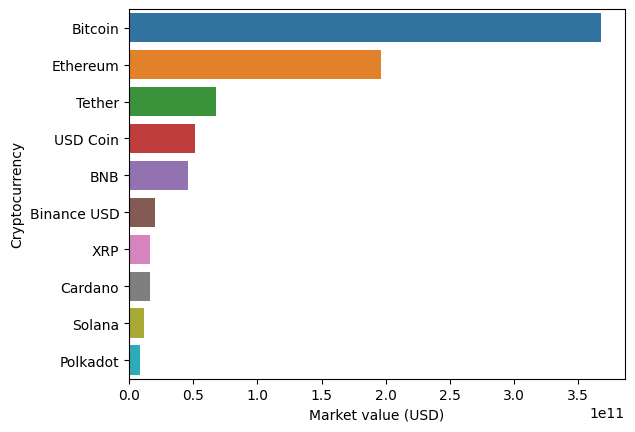

In [101]:
sns.barplot(x = "market_cap", y = "name", data = currencies_df.head(10))
plt.xlabel("Market value (USD)")
plt.ylabel("Cryptocurrency")
plt.show()

Now we will plot the same chart be using the currency volume this time.

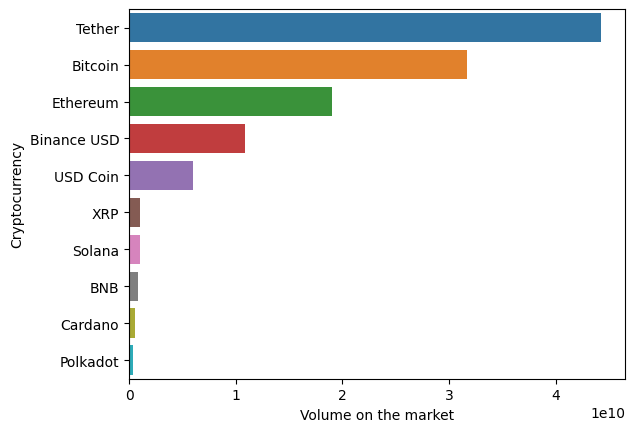

In [102]:
sns.barplot(x = "volume", y = "name", data = currencies_df.head(10).sort_values(by="volume", ascending=False))
plt.xlabel("Volume on the market")
plt.ylabel("Cryptocurrency")
plt.show()

As we can see from the two plots, the currencies at the top 3 are the same when it comes to market value and volume. therefore we are going to limit this analysis to these 3 currencies.

Firstly, we need to fetch data about the currencies from the API. we have already done it for Bitcoin. Let's do the same thing with Ethereum and Tether.

In [103]:
# Retreiving Ethereum and tether data.

ethereum_df = coin_historical_data('ethereum')
tether_df = coin_historical_data('tether')

#### Candlestick charts

Now that we have all the required data, we are able to do more advanced analysis on currency prices. One way to do this is by analyzing candlestick charts. They give a much more clear idea about price changes during a certain period of time, which will hopefully allow us to have a better understanding about a specific currency in the market.

In [104]:
def plot_candlestick(df):
    """
    When called, this function plots a candlestick chart.
    
    Params:
    -------
        df (pandas.DateFrame) - data about a specific currency.
        period () - 
    """
    
    fig = go.Figure(data = [go.Candlestick(x=df['date'], 
                                           open = df['open'],
                                           high = df['high'],
                                           low = df['low'],
                                           close = df['close'],)])
    fig.show()

Bitcoin's candlestick chart :

In [105]:
plot_candlestick(bitcoin_df)

Ethereum's candlestick chart :

In [106]:
plot_candlestick(ethereum_df)

tether's candlestick chart :

In [107]:
plot_candlestick(tether_df)